In [93]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, signal, optimize
from tqdm import tqdm
import h5py
import pandas as pd

# Global parameters

In [94]:
# global parameters
dt=1
epsilon=0.2
sigma=0.01
N=int(1e4)
mu=0.2

In [95]:
#mean field solution for T->inf
def a_inf(lam, mu, h):
    return mu*(1-np.exp(-h*dt))/(1-lam*(1-mu)-lam*mu*np.exp(-h*dt))

lam=0.0
print(lam, mu, a_inf(lam, mu, 0), a_inf(lam, mu, 1e3))

0.0 0.2 0.0 0.2


# Implementation of measures

### 1. Find smallest $h$ for which the overlap with the zero-input case is less than discrimination error $\varepsilon$
Note: $a(0)=0$ for all $\lambda$ and $\mu$ such that $P(o)=\mathcal{N}(0,\sigma)$

In [96]:
def calc_overlap(pmf1, pmf2):
    """
    calculates the overlap between two discrete probability mass functions
    ATTENTION: needs user to ensure that domains are identical!
    """
    assert len(pmf1) == len(pmf2)
    return np.sum(np.minimum(pmf1, pmf2)) * 0.5


def find_discriminable_inputs(pmf, h_range, pmf_refs, epsilon:float, start="left"):
    """
    Determine all inputs h in range h_range such that the overlap between all pmfs is less than epsilon
    The pmfs of h_range[0] and h_range[1] sever as boundaries

    # Parameter
    - pmf: function
    - h_range: array-like with length two
    - epsilon: float
        discrimination error that specifies maximal overlap between two probability mass functions
    """
    assert len(h_range) == 2
    h_left, h_right = h_range
    hs = []

    if start == "left": 
        h_ref = h_left
        pmf_ref = pmf_refs[0]
        pmf_end = pmf_refs[1]
    if start == "right":
        h_ref = h_right
        pmf_ref = pmf_refs[1]
        pmf_end = pmf_refs[0]

    while True:
        def func(h):
            return calc_overlap(pmf_ref, pmf(h)) - epsilon

        try:
            if start == "left":
                h_new = optimize.bisect(func, h_ref, h_right)
            elif start=="right":
                h_new = optimize.bisect(func, h_left, h_ref)
            pmf_new = pmf(h_new)
            if calc_overlap(pmf_end, pmf_new) < epsilon:
                hs.append(h_new)
                h_ref = h_new
                pmf_ref = pmf_new
            else:
                break
        except:
            break
    return hs


def dynamic_range(h_range):
    """
    Calculate the dynamic range from the range h_range
    """
    assert len(h_range) == 2
    h_left, h_right = h_range
    return 10 * (np.log10(h_right) - np.log10(h_left))

[0.08791606053470957, 0.18431236719523952, 0.29100251598853466, 0.4104503188933367, 0.5461252499403776, 0.7031418123652079, 0.8894902142984816, 1.1187026753957172, 1.4165832197970933, 1.8427656613551464]
[2.475008763296316, 1.7818644298757167, 1.3763986698980624, 1.088715806871806, 0.865573098429537, 0.6832514514483375, 0.5291001765680747, 0.3955692722790745, 0.2777862803291233, 0.1724252431424893]


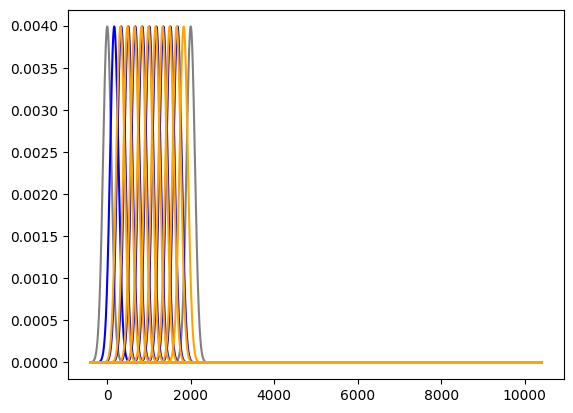

In [97]:
# test discriminable intervals
lam = 0.0
Xs = np.arange(-4*sigma*N,N+4*sigma*N)

def pmf(h):
    # see below for formal derivation, here just as a test
    A = mu*(1-np.exp(-h*dt))/(1-lam*(1-mu)-lam*mu*np.exp(-h*dt)) * N
    # in domain with delta = 1
    delta = 1
    return stats.norm.pdf(Xs, A, sigma*N)*delta

h_range=[0,1e3]
pmf_ref_left = pmf(h_range[0])
pmf_ref_right = pmf(h_range[1])

plt.plot(Xs,pmf_ref_left, color="gray")
plt.plot(Xs,pmf_ref_right, color="gray")

hs_left = find_discriminable_inputs(pmf, h_range, [pmf_ref_left, pmf_ref_right], epsilon, start="left")
print(hs_left)
for h in hs_left:
    plt.plot(Xs,pmf(h), color="blue")

hs_right = find_discriminable_inputs(pmf,h_range, [pmf_ref_left, pmf_ref_right], epsilon, start="right")
print(hs_right)
for h in hs_right:
    plt.plot(Xs,pmf(h), color="orange")
#plt.legend()

# Consider network output with Gaussian noise
The output of the network is the sum of the network activity and Gaussian noise $\eta\sim\mathcal{N}(0,1)$ such that 
$$ o = a + \sigma\eta $$
The output is thus a convolution between $P(a)$ and $\mathcal{N}(0,\sigma)$.

For $T\to\infty$ the distribution of activity is a delta-distribution such that the the output distribution becomes a shifted Gaussian
$$ P(o) = \mathcal{N}(a(h|\lambda,\mu), \sigma)$$

# Analytic solution for $T\to\infty$
For the $T\to\infty$ case, we have a one-to-one mapping between input $h$ and network activity $a$, given by 
$$a(h|\lambda, \mu) = \frac{\mu\left(1-e^{-h\Delta t}\right)}{1-\lambda(1-\mu)-\lambda\mu e^{-h\Delta t}}$$

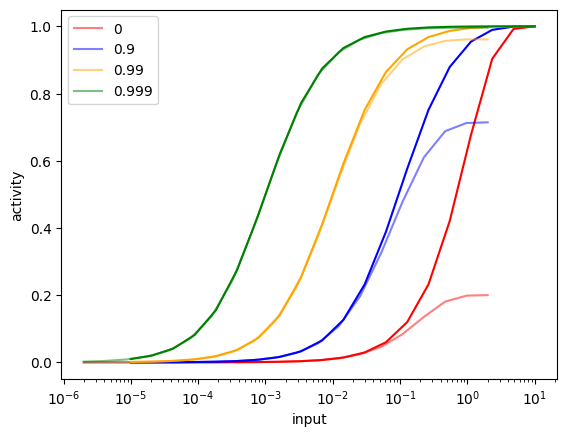

In [99]:
hs=np.logspace(-5,1,20)
colors=['red','blue','orange','green']
for i,lam in enumerate([0,0.9,0.99,0.999]):
    plt.plot(hs*0.2, a_inf(lam, mu, hs), label='{}'.format(lam), color=colors[i], alpha=0.5)
    plt.plot(hs, a(hs, lam, 1.0), color=colors[i])
plt.xscale("log")
plt.xlabel("input")
plt.ylabel("activity")
plt.legend()

100%|██████████| 30/30 [00:26<00:00,  1.12it/s]


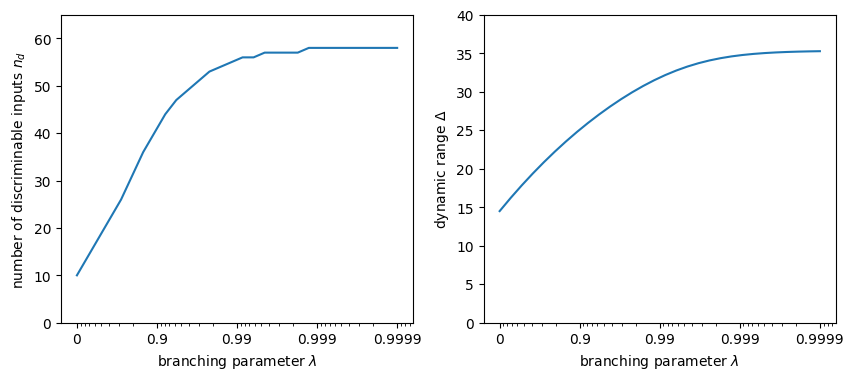

In [100]:
# network parameters
Xs = np.arange(-4 * sigma * N, N + 4 * sigma * N)
lams_inf = 1 - np.logspace(-4, 0, 30)

# analysis parameters
drs_inf = np.zeros(len(lams_inf))
nds_inf = np.zeros(len(lams_inf))
h_range = [0, 1e3]
# attempt to match previous data analysis
logh = np.arange(-7, 1.5, 0.05)  # 170 elements

for i, lam in tqdm(enumerate(lams_mf), total=len(lams_mf)):
    # distribution of noisy output
    def pmf_o_given_h(h):
        A = a(h, lam, mu) * N
        return stats.norm.pdf(Xs, A, sigma * N)

    pmf_ref_left = pmf_o_given_h(h_range[0])
    pmf_ref_right = pmf_o_given_h(h_range[1])
    hs_left = find_discriminable_inputs(pmf_o_given_h, h_range, [pmf_ref_left, pmf_ref_right], epsilon)
    hs_right = find_discriminable_inputs(pmf_o_given_h, h_range, [pmf_ref_left, pmf_ref_right], epsilon, start="right")
    drs_inf[i] = dynamic_range((hs_left[0], hs_right[0]))
    nds_inf[i] = 0.5 * (len(hs_left) + len(hs_right))

# plot the number of discriminable inputs for different values of epsilon and T in a main plot with an inset
markers = ["o", "s", "^", "P", "d"]
legends = ["$1$ ms", "$10$ ms", "$10^2$ ms", "$10^3$ ms", "$10^4$ ms"]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(1 - lams_inf, nds_inf)
ax[0].set_xlabel("branching parameter $\lambda$")
ax[0].set_ylim(0, 65)
ax[0].set_ylabel("number of discriminable inputs $n_d$")
ax[0].set_xscale("log")
ax[0].set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax[0].set_xticklabels(["0.9999", "0.999", "0.99", "0.9", "0"])
ax[0].invert_xaxis()
ax[1].plot(1 - lams_inf, drs_inf)
ax[1].set_xlabel("branching parameter $\lambda$")
ax[1].set_ylim(0, 40)
ax[1].set_ylabel("dynamic range $\Delta$")
ax[1].set_xscale("log")
ax[1].set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax[1].set_xticklabels(["0.9999", "0.999", "0.99", "0.9", "0"])
ax[1].invert_xaxis()

# Analysis of data

In [101]:
beta_approximation = "./dat/beta_approximation_simulation.h5"

# show content of file with visit function
# with h5py.File(beta_approximation, "r") as f:
#     f.visit(print)

# create empty pandas dataframe with colums [window, lam, h, seed, a, b, loc, scale]
df = pd.DataFrame(columns=["window", "lam", "h", "seed", "a", "b", "loc", "scale"])
# iterate over all groups in file and add to dataframe
with h5py.File(beta_approximation, "r") as f:
    for window in f.keys():
        for lam in f[window].keys():
            for h in f[window][lam].keys():
                for seed in f[window][lam][h].keys():
                    fit = np.array(f[window][lam][h][seed])
                    a = fit[0]
                    b = fit[1]
                    loc = fit[2]
                    scale = fit[3]
                    df.loc[len(df)] = {
                        "window": float(window),
                        "lam": float(lam),
                        "h": float(h),
                        "seed": int(seed),
                        "a": a,
                        "b": b,
                        "loc": loc,
                        "scale": scale  
                    }
print(df)

        window     lam         h  seed            a              b     loc  \
0     1.000000  0.0000  0.000100  1000    14.808305  123437.909027 -0.0001   
1     1.000000  0.0000  0.000126  1000    13.215659  105610.988024 -0.0001   
2     1.000000  0.0000  0.000158  1000    11.874985   90205.258274 -0.0001   
3     1.000000  0.0000  0.000200  1000    10.764795   76984.736030 -0.0001   
4     1.000000  0.0000  0.000251  1000     9.894010   65869.123281 -0.0001   
...        ...     ...       ...   ...          ...            ...     ...   
5197  0.000001  0.9999  3.162278  1000  4513.446087       2.356494 -0.0001   
5198  0.000001  0.9999  3.981072  1000  4646.903952       2.367591 -0.0001   
5199  0.000001  0.9999  5.011872  1000  4715.214832       2.373272 -0.0001   
5200  0.000001  0.9999  6.309573  1000  4743.555743       2.375827 -0.0001   
5201  0.000001  0.9999  7.943282  1000  4751.837193       2.376472 -0.0001   

       scale  
0     1.0002  
1     1.0002  
2     1.0002  
3  

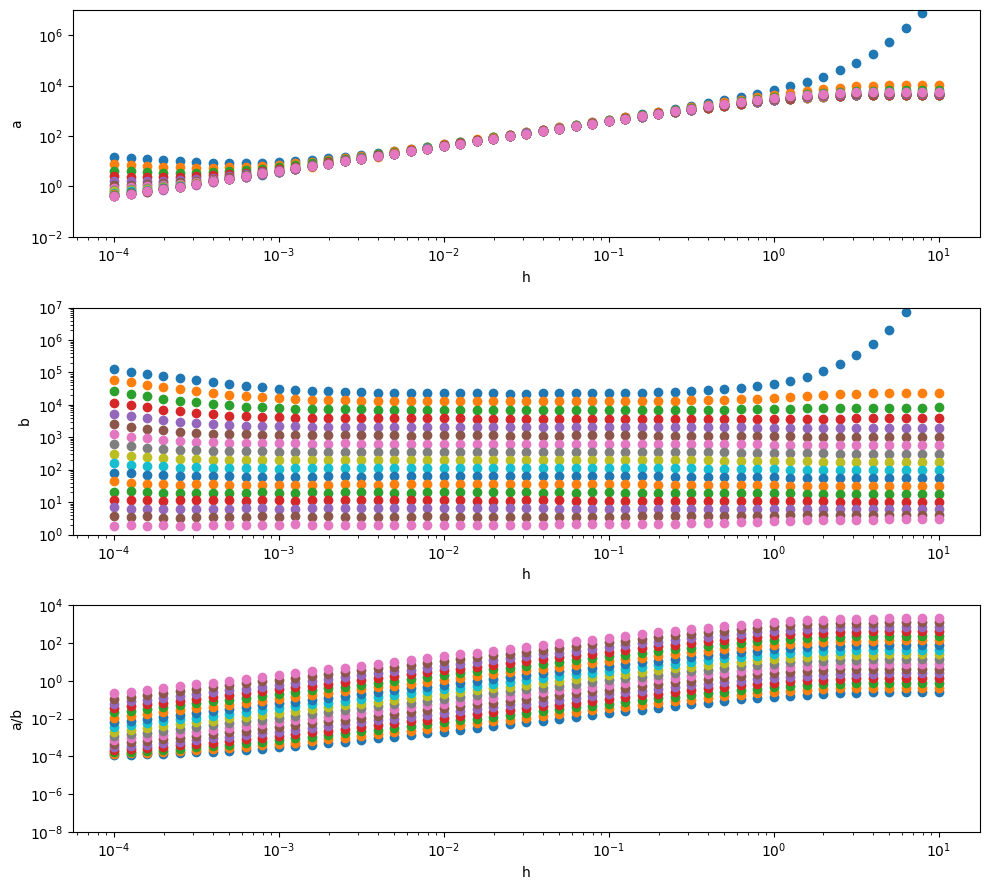

In [3]:
# plot beta parameters for different windows and lambdas from dataframe
fig, axes = plt.subplots(3, 1, figsize=(10, 9))
windows = df["window"].unique()
lambdas = df["lam"].unique()
hs = df["h"].unique()
seeds = df["seed"].unique()
# reverse the order of the windows

window=1
#lam=0.9
#for window in sorted(windows)[::-1]:
for lam in lambdas:
    df_temp = df[(df["window"] == window) & (df["lam"] == lam)]
    axes[0].scatter(df_temp["h"].values, df_temp["a"], label="{} {}".format(window, lam))
    axes[1].scatter(df_temp["h"].values, df_temp["b"], label="{} {}".format(window, lam))
    axes[2].scatter(df_temp["h"].values, df_temp["a"] / df_temp["b"], label="{} {}".format(window, lam))

axes[0].set_xlabel("h")
axes[1].set_xlabel("h")
axes[2].set_xlabel("h")
axes[0].set_ylabel("a")
axes[1].set_ylabel("b")
axes[2].set_ylabel("a/b")

axes[0].set_yscale("log")
axes[1].set_yscale("log")
axes[2].set_yscale("log")

axes[0].set_xscale("log")
axes[1].set_xscale("log")
axes[2].set_xscale("log")

axes[0].set_ylim(1e-2, 1e7)
axes[1].set_ylim(1e0, 1e7)
axes[2].set_ylim(1e-8, 1e4)

#axes[0].legend(loc='upper left')
plt.tight_layout()

Fit the available data with a deep neural network that maps system parameters (h,epsilon) to beta-distribution parameters (a,b)

In [4]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [24]:
import sklearn
from sklearn.preprocessing import MinMaxScaler

def get_data(dataframe, shuffle=1234):
    # x data is a stack of the columns (window, lam, h)
    X = dataframe[["window", "lam", "h"]].values
    # transform into log space
    X[:,0] = np.log10(X[:,0])
    X[:,1] = np.log10(1-X[:,1])
    X[:,2] = np.log10(X[:,2])
    # y data is a stack of the columns (a, b, loc, scale)
    Y = dataframe[["a", "b", "loc", "scale"]].values
    # transform a, b, into log space
    Y[:,0] = np.log10(Y[:,0])
    Y[:,1] = np.log10(Y[:,1])
    print(X.shape, Y.shape)
    # shuffle with random mask
    mask = np.arange(len(X))
    # if shuffle is not False:
    if shuffle is not None:
        np.random.seed(shuffle)
        np.random.shuffle(mask)
    return X[mask], Y[mask], 
get_data(df, shuffle=None)

(5202, 3) (5202, 4)


(array([[ 0. ,  0. , -4. ],
        [ 0. ,  0. , -3.9],
        [ 0. ,  0. , -3.8],
        ...,
        [-6. , -4. ,  0.7],
        [-6. , -4. ,  0.8],
        [-6. , -4. ,  0.9]]),
 array([[ 1.17050535e+00,  5.09144856e+00, -1.00000000e-04,
          1.00020000e+00],
        [ 1.12108882e+00,  5.02370911e+00, -1.00000000e-04,
          1.00020000e+00],
        [ 1.07463307e+00,  4.95523185e+00, -1.00000000e-04,
          1.00020000e+00],
        ...,
        [ 3.67350148e+00,  3.75347586e-01, -1.00000000e-04,
          1.00020000e+00],
        [ 3.67610401e+00,  3.75814863e-01, -1.00000000e-04,
          1.00020000e+00],
        [ 3.67686155e+00,  3.75932646e-01, -1.00000000e-04,
          1.00020000e+00]]))

We follow here the [simple example](https://notebook.community/kit-cel/lecture-examples/mloc/ch3_Deep_Learning/pytorch/function_approximation_with_MLP) using pytorch

Define the model

TODO: In principle we know the $h->0$ and $h->\infty$ solution from the $T->\infty$ solution. Can we make use of this?

(5202, 3) (5202, 4)


  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [01:15<00:00, 131.79it/s]


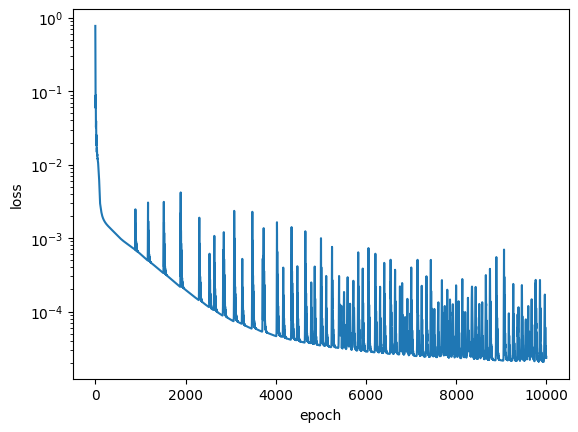

In [25]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(3, 42)
        self.act1 = nn.Tanh()
        self.hidden2 = nn.Linear(42, 42)
        self.act2 = nn.Tanh()
        self.hidden3 = nn.Linear(42, 42)
        self.act3 = nn.Tanh()
        self.output = nn.Linear(42, 4)
        #self.act_output = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.act3(self.hidden3(x))
        x = self.output(x)
        return x
 

def train_model_simple(X_train, Y_train, epochs):
    """
    Trains a simple neural network with one hidden layer with units neurons
    """
    # prepare data
    X_train_tensor = torch.from_numpy(X_train).float()
    Y_train_tensor = torch.from_numpy(Y_train).float()

    # create model
    model = NeuralNetwork()

    # Adam and MSE Loss
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    loss_fn = nn.MSELoss(reduction='mean')
    
    # main loop    
    history_loss = []
    for epoch in tqdm(range(epochs)):
        yhat = model(X_train_tensor)
        loss = loss_fn(yhat, Y_train_tensor)
        history_loss.append(loss.item())
        # compute gradients
        loss.backward() 
        # carry out one optimization step with Adam
        optimizer.step()   
        # reset gradients to zero
        optimizer.zero_grad()

    return model, history_loss

# rescale data (can use the same scaler multiple times using fit_transform function)
X_scaler = MinMaxScaler(feature_range=(-1, 1))
Y_scaler = MinMaxScaler(feature_range=(-1, 1))
X, Y = get_data(df)
X_scaled = X_scaler.fit_transform(X)
Y_scaled = Y_scaler.fit_transform(Y)

# train model
model, loss = train_model_simple(X_scaled, Y_scaled, 10000)
plt.plot(loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.yscale('log')
plt.show()


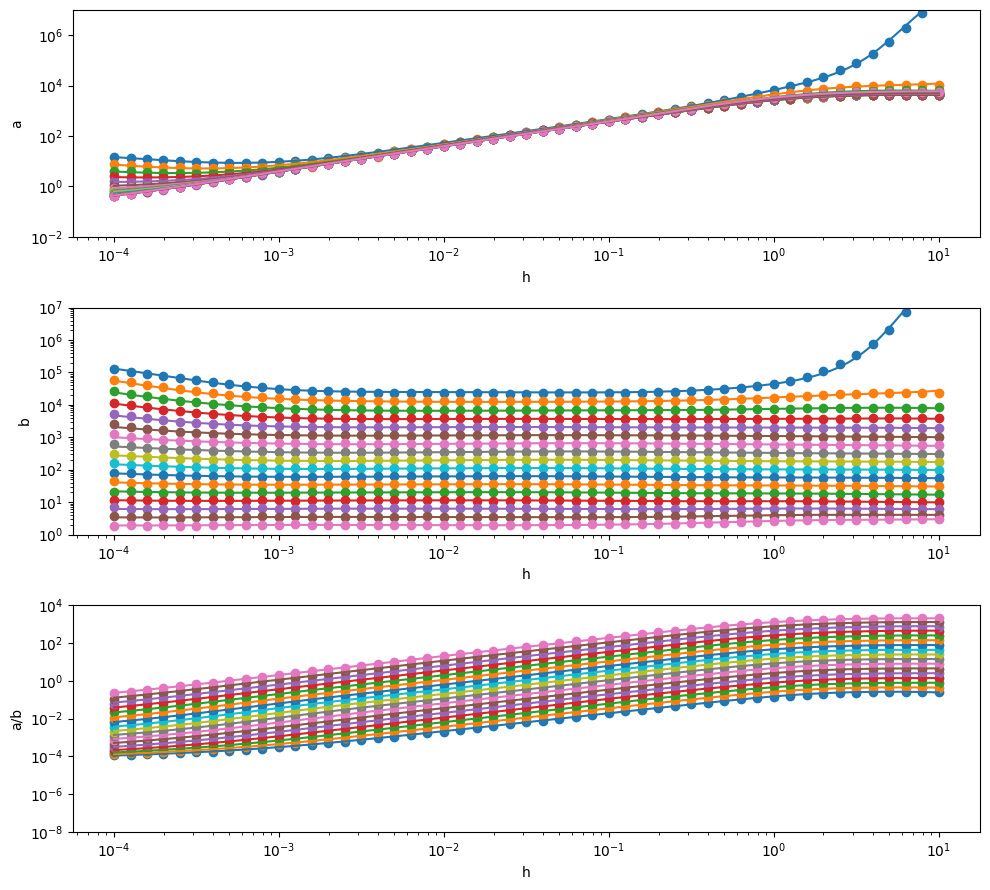

In [28]:
import itertools
import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 1, figsize=(10, 9))

# mesh grid for contour plot
log10hs = np.linspace(-4, 1, 200)

windows = df["window"].unique()
lambdas = df["lam"].unique()
hs = df["h"].unique()
seeds = df["seed"].unique()
# reverse the order of the windows

window=1
#lam=0.9
#for window in sorted(windows)[::-1]:
for lam in lambdas:
    df_temp = df[(df["window"] == window) & (df["lam"] == lam)]
    X_model = np.dstack([np.log10(window)*np.ones_like(log10hs), np.log10(1-lam)*np.ones_like(log10hs), log10hs]).reshape(-1, 3)
    X_model_scaled = X_scaler.transform(X_model)
    Y_model_scaled = model(torch.from_numpy(X_model_scaled).float()).detach().numpy()
    Y_model = Y_scaler.inverse_transform(Y_model_scaled)

    a_model = 10**Y_model[:, 0]
    b_model = 10**Y_model[:, 1]

    ref = axes[0].scatter(df_temp["h"].values, df_temp["a"], label="{} {}".format(window, lam))
    axes[0].plot(10**log10hs, a_model, color=ref.get_facecolor()[0])
    axes[1].scatter(df_temp["h"].values, df_temp["b"], label="{} {}".format(window, lam))
    axes[1].plot(10**log10hs, b_model, color=ref.get_facecolor()[0])
    axes[2].scatter(df_temp["h"].values, df_temp["a"] / df_temp["b"], label="{} {}".format(window, lam))
    axes[2].plot(10**log10hs, a_model/b_model, color=ref.get_facecolor()[0])

axes[0].set_xlabel("h")
axes[1].set_xlabel("h")
axes[2].set_xlabel("h")
axes[0].set_ylabel("a")
axes[1].set_ylabel("b")
axes[2].set_ylabel("a/b")

axes[0].set_yscale("log")
axes[1].set_yscale("log")
axes[2].set_yscale("log")

axes[0].set_xscale("log")
axes[1].set_xscale("log")
axes[2].set_xscale("log")

axes[0].set_ylim(1e-2, 1e7)
axes[1].set_ylim(1e0, 1e7)
axes[2].set_ylim(1e-8, 1e4)

#axes[0].legend(loc='upper left')
plt.tight_layout()

### Convolution of beta distribution with Guassian 

In [71]:
delta = 1/N
support = np.arange(0, 1+4*sigma, delta)
support = np.concatenate((-support[::-1], support[1:]))

def ml_pmf(window, lam, h, verbose=False):
    # distribution is given by Beta-distribution specified by a and b
    X = np.log10(np.array([window, 1-lam, h]))
    X_scaled = X_scaler.transform(X.reshape(-1,1).T)
    Y_scaled = model(torch.from_numpy(X_scaled).float()).detach().numpy()
    log10a, log10b, loc, scale = Y_scaler.inverse_transform(Y_scaled).T.reshape(-1)
    a,b = 10**log10a, 10**log10b
    pmf_beta = stats.beta.pdf(support, a, b, loc=loc, scale=scale)*delta
    # check for special cases with vanishing pmf
    if np.sum(pmf_beta) < 0.5:
        print(f'ERROR: (a,b)=({a},{b}) vanishing beta distribution with sum(pmf)={np.sum(pmf_beta)}')
    # check for special cases that result in delta distribution (find any pmf_beta to be infinity)
    if np.any(pmf_beta==np.inf):
        if verbose:
            print(f'WARNING: (a,b)=({a},{b}) infinity encountered in beta distribution, converted to pmf with single probable state')
        mask = pmf_beta==np.inf
        pmf_beta[mask] = 1
        pmf_beta[~mask] = 0
        if np.sum(pmf_beta) != 1:
            print("ERROR: pmf not normalized to 1")
    pmf_norm = stats.norm.pdf(support, 0, sigma)*delta
    # convolution with a Gaussian distribution at every point of the support
    return np.convolve(pmf_beta, pmf_norm, mode="same")

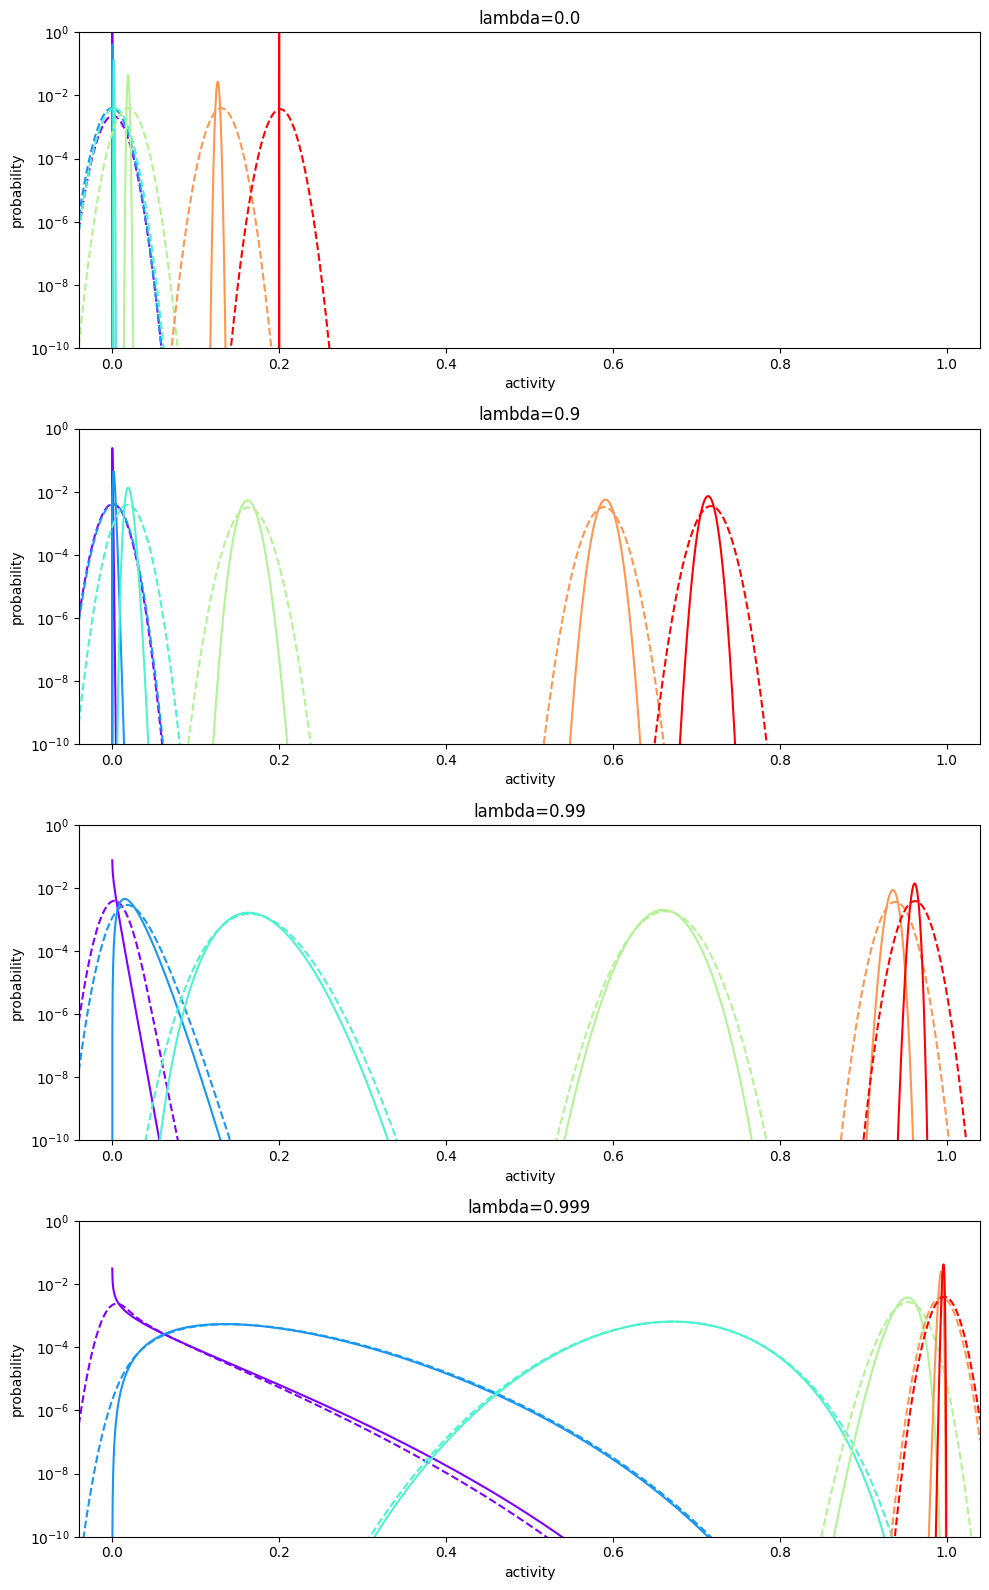

In [47]:
from matplotlib.pyplot import cm

# plot resulting distributions for different values of h and epsilon
list_lam = [0.0, 0.9, 0.99, 0.999]
fig, axes = plt.subplots(len(list_lam),1, figsize=(10, 4*len(list_lam)))

list_hs = 10**np.linspace(-4, 1, 6)
for (i,lam) in enumerate(list_lam):
    color = iter(cm.rainbow(np.linspace(0, 1, len(list_hs))))
    for h in list_hs:
        a,b,loc,scale = df.loc[ (df['window']==1) & (df['lam']==lam) & (df['h']==h) ].values[0][4:]
        c = next(color)
        pmf_beta = stats.beta.pdf(support, a, b, loc=loc, scale=scale)*delta
        axes[i].plot(support, pmf_beta, color=c)
        # from ML dashed
        pmf_ml = ml_pmf(window, lam, h)
        axes[i].plot(support, pmf_ml, color=c, linestyle='--')
        axes[i].set_xlim(0-4*sigma,1+4*sigma)
        axes[i].set_xlabel("activity")
        axes[i].set_ylabel("probability")
        axes[i].set_title("lambda={}".format(lam))
        axes[i].set_yscale("log")
        axes[i].set_ylim(1e-10, 1e0)
plt.tight_layout()


From the interpolation model we can obtain estimates of the dynamic range and the resolution

Important: Need to be able to specify reference distributions! Else we cannot parse no/full activity for simulations. Reference could come from infinite-T solution plus Gaussian!

0.0
hs_left:  [0.08782189050361577, 0.1882872581479299, 0.29812093946521323, 0.4174179148769301, 0.5481328837359384, 0.6942261248400443, 0.8621326042641732, 1.0623240735175774, 1.3132742777819622, 1.6524927924461332]
hs_right:  [2.039411442663879, 1.569366410945389, 1.2539738829977412, 1.0160948272577337, 0.8239880780668063, 0.661446823127641, 0.5190807017982929, 0.39106682951268806, 0.27388737260771434, 0.16601177194472724]


(-0.04, 1.04)

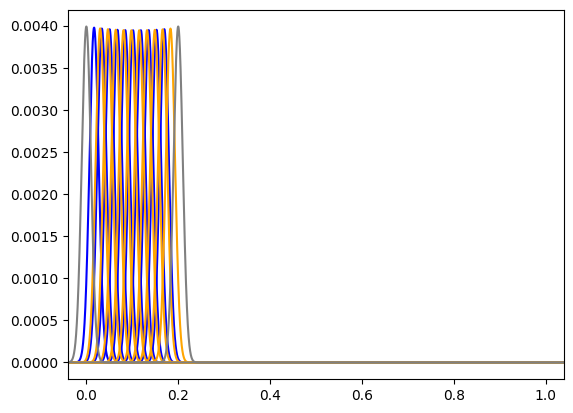

In [102]:
# test discriminable intervals
lam = 0.0
window = 1 
def _pmf(h):
    return ml_pmf(window, lam, h)

# has to be in range of data! (lam=0 there is sth odd with the data fit?)
h_range=[10**-4,10]
# pmf from Gaussians around mean-field solution for h=0 and h->infty
# support defined above!
print(mf_activity(lam, mu, 0))
pmf_ref_left = stats.norm.pdf(support, mf_activity(lam, mu, 0), sigma)*delta
pmf_ref_right = stats.norm.pdf(support, mf_activity(lam, mu, 1e3), sigma)*delta

hs_left = find_discriminable_inputs(_pmf, h_range, [pmf_ref_left, pmf_ref_right], epsilon, start="left")
print("hs_left: ", hs_left)
for h in hs_left:
    plt.plot(support, _pmf(h), color="blue")

hs_right = find_discriminable_inputs(_pmf, h_range, [pmf_ref_left, pmf_ref_right], epsilon, start="right")
print("hs_right: ", hs_right)
for h in hs_right:
    plt.plot(support, _pmf(h), color="orange")

plt.plot(support, pmf_ref_left, color="gray")
plt.plot(support, pmf_ref_right, color="gray")
plt.xlim(0-4*sigma,1+4*sigma)

# plt.legend()

In [103]:
lams = np.sort(df['lam'].unique())

# analysis parameters
drs = np.zeros(len(lams))
nds = np.zeros(len(lams))
mis = np.zeros(len(lams))

# need to exclude the zero here because of logh fit
h_range=[10**-4, 10]

for i, lam in tqdm(enumerate(lams), total=len(lams)):
    print(i,lam)
    # distribution is given by Beta-distribution specified by a and b
    def pmf_o_given_h(h):
        return ml_pmf(window, lam, h)
    pmf_ref_left = stats.norm.pdf(support, mf_activity(lam, mu, 0), sigma)*delta
    pmf_ref_right = stats.norm.pdf(support, mf_activity(lam, mu, 1e3), sigma)*delta
    hs_left = find_discriminable_inputs(pmf_o_given_h, h_range, [pmf_ref_left, pmf_ref_right], epsilon)
    hs_right = find_discriminable_inputs(pmf_o_given_h, h_range, [pmf_ref_left, pmf_ref_right], epsilon, start="right")
    # print(hs_left,hs_right)
    if len(hs_left) > 0 and len(hs_right) > 0:
        drs[i] = dynamic_range((hs_left[0], hs_right[0]))
        nds[i] = 0.5 * (len(hs_left) + len(hs_right))
    else:
        drs[i] = 0
        nds[i] = 0


  0%|          | 0/17 [00:00<?, ?it/s]

0 0.0


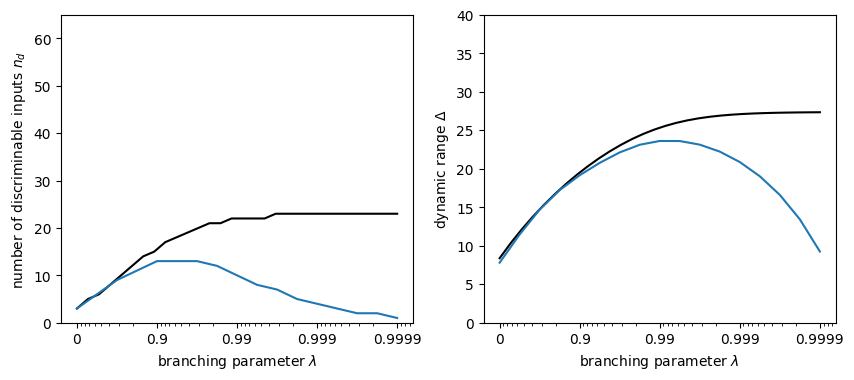

In [88]:
# plot the number of discriminable inputs for different values of epsilon and T in a main plot with an inset
markers = ["o", "s", "^", "P", "d"]
legends = ["$1$ ms", "$10$ ms", "$10^2$ ms", "$10^3$ ms", "$10^4$ ms"]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(1 - lams_mf, nds_inf, label="inf", color="black")
ax[0].plot(1 - lams, nds)
ax[0].set_xlabel("branching parameter $\lambda$")
ax[0].set_ylim(0, 65)
ax[0].set_ylabel("number of discriminable inputs $n_d$")
ax[0].set_xscale("log")
ax[0].set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax[0].set_xticklabels(["0.9999", "0.999", "0.99", "0.9", "0"])
ax[0].invert_xaxis()
ax[1].plot(1 - lams_mf, drs_inf, label="inf", color="black")
ax[1].plot(1 - lams, drs)
ax[1].set_xlabel("branching parameter $\lambda$")
ax[1].set_ylim(0, 40)
ax[1].set_ylabel("dynamic range $\Delta$")
ax[1].set_xscale("log")
ax[1].set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax[1].set_xticklabels(["0.9999", "0.999", "0.99", "0.9", "0"])
ax[1].invert_xaxis()

## TODO:
- Develop an approximation to the finite-time solution as a correction to the infinite T limit?
- Fit this?
- Or take absolute maximum? -> as inset?
- Only Fig n_d and DR ... Lets try to replot with development of maxima as inset
